# DenseNet

* 참조 

  - https://arxiv.org/abs/1608.06993

DenseNet은 2016년에 논문을 통해 발표된 CNN 모델이다. DenseNet은 ResNet의 skip connection과 다른 Dense connectivity를 제안했다. 이 모델의 장점으로는 이미지에서 저수준의 특징들이 잘 보존되고, gradient가 수월하게 흘러 gradient vanishing 문제가 발생하지 않으며, 깊이에 비해 파라미터 수가 적기에 연산량이 절약됨과 동시에 적은 데이터셋에서도 비교적 잘 학습이 된다는 점이 있다. 

#### Dense connectivity 

<img src="https://datascienceschool.net/upfiles/0f67048679484e6ba681e5e1d941d40b.png"  style="width: 100%;">

그림 18.4.9 : Dense Connectivity 

DenseNet의 핵심은 Dense connectivity 이다. Dense connectivity 란, 입력값을 계속해서 출력값의 채널 방향으로 합쳐주는 것(Concat)인데, 이를  ResNet과 수식으로 비교하면, 다음과 같다. 
$$x_{l+1} = F(x_l) + x_l$$
$$x_{l+1} = F([x_0, x_1 \cdots, x_{l}])$$ 

ResNet의 경우에는 입력이 출력에 더해지는 것이기 때문에 종단에 가서는 최초의 정보가 흐려질 수 밖에 없다. 그에 반해 DenseNet의 경우에는 채널 방향으로 그대로 합쳐지는 것이기 때문에 최초의 정보가 비교적 온전히 남아있게 된다. 

### DenseNet 구조

#### DenseNet-121

|  유형  |입력 크기 | 출력 크기 | 커널 크기 | 횟수 |
|:--|:------:|:-------:|------------|:-------:|
|**입력**|(224,224,3)| |||
|**Conv**|(224,224,3)|(112,112,64)|(7,7)||
|**maxpool**|(112,112,64)|(56,56,64)|(3,3)||
|**Dense Block**|(56,56,64)|(56,56,256)|$\begin{bmatrix} 1\times1,128 \\ 3\times3,32 \end{bmatrix}\;\;$ |$\times 6$|
|**Conv**|(56,56,256)|(56,56,128)|(1,1)||
|**Average pool**|(56,56,128)|(28,28,128)|(2,2)||
|**Dense Block**|(28,28,128)|(28,28,512)|$\begin{bmatrix} 1\times1,128 \\ 3\times3,32 \end{bmatrix}\;\;$ |$\times 12$|
|**Conv**|(28,28,512)|(28,28,256)|(1,1)||
|**Average pool**|(28,28,256)|(14,14,256)|(2,2)||
|**Dense Block**|(14,14,256)|(14,14,1024)|$\begin{bmatrix} 1\times1,128 \\ 3\times3,32 \end{bmatrix}\;\;$ |$\times 24$|
|**Conv**|(14,14,1024)|(14,14,512)|$1\times1,512$||
|**Average pool**|(14,14,512)|(7,7,512)|(2,2)||
|**Dense Block**|(7,7,512)|(7,7,1024)|$\begin{bmatrix} 1\times1,128 \\ 3\times3,32 \end{bmatrix}\;\;$ |$\times 16$|
|**Average pool**|(7,7,1024)|(1,1,1024)|(7,7)|1|
|**FCN**|(1,1,2048|(1,1,1000)|||
|**softmax**|(1,1,1000)|(1,1,1000)|||

표 18.4.6 : DenseNet-121 구조

표 18.4.6는 DenseNet의 구조를 표현한 것이다. 첫번째 convolution과 maxpooling 연산은 ResNet과 똑같다. 이 후 Dense Block과 Transition layer가 반복되고, 마지막의 fully connected layer와 softmax로 예측을 수행한다. 

#### Dense Block 

Dense connectivity를 적용하기 위해서는 피쳐맵의 크기가 동일해야한다. 같은 피쳐맵 크기를 공유하는 연산을 모아서 Dense Block을 구성하고 이 안에서 Dense connectivity를 적용한다. 이 때, ResNet에서 배웠던 병목레이어를 사용한다. 이 또한 연산량을 줄이기 위해 적용한 것이다. 그리고, DenseNet의 경우, 전체 convolution 연산의 출력 피쳐맵 갯수가 동일하다. 이 피쳐맵의 갯수를 `growth rate`라고 하고 $k$로 표현한다. 이는 하이퍼 파라미터이며, 논문에서는 $k=32$로 설정하였다. 따라서, Dense Block 내의 3x3 convolution 연산의 출력 피쳐맵의 갯수는 32이다.  1x1 convolution의 출력 피쳐맵의 갯수 또한 하이퍼 파라미터 이지만, 논문에서 $4k$를 추천한다. 따라서 Dense Block 내의 1x1 convolution 연산의 출력 피쳐맵 갯수는 128이다. 

#### Transition layer 

표 18.4.6 에서 Dense Block 사이에 있는 1x1 convolution 연산과 average pooling 연산을 묶어 Transition layer 라고 한다. 이 부분을 통과하면서 피쳐맵의 크기가 줄어들게 된다. 앞에 있는 1x1 convolution은 다음 Dense Block으로 전해지는 피쳐맵의 갯수를 조절하는 역할을 한다. 입력되는 피쳐맵의 갯수를 $m$이라고 했을 때,  $[\theta m], (0 < \theta \leq1)$을 출력하는 피쳐맵의 갯수로 한다. $\theta$ 또한 하이퍼 파리미터로 논문에서는 0.5로 설정했다. 

In [1]:
from keras.applications.densenet import DenseNet121, decode_predictions

dense = DenseNet121()
# dense.summary()

Using TensorFlow backend.


테스트 시 소요 시간 : 1.6927518844604492
analog_clock (99.75%)


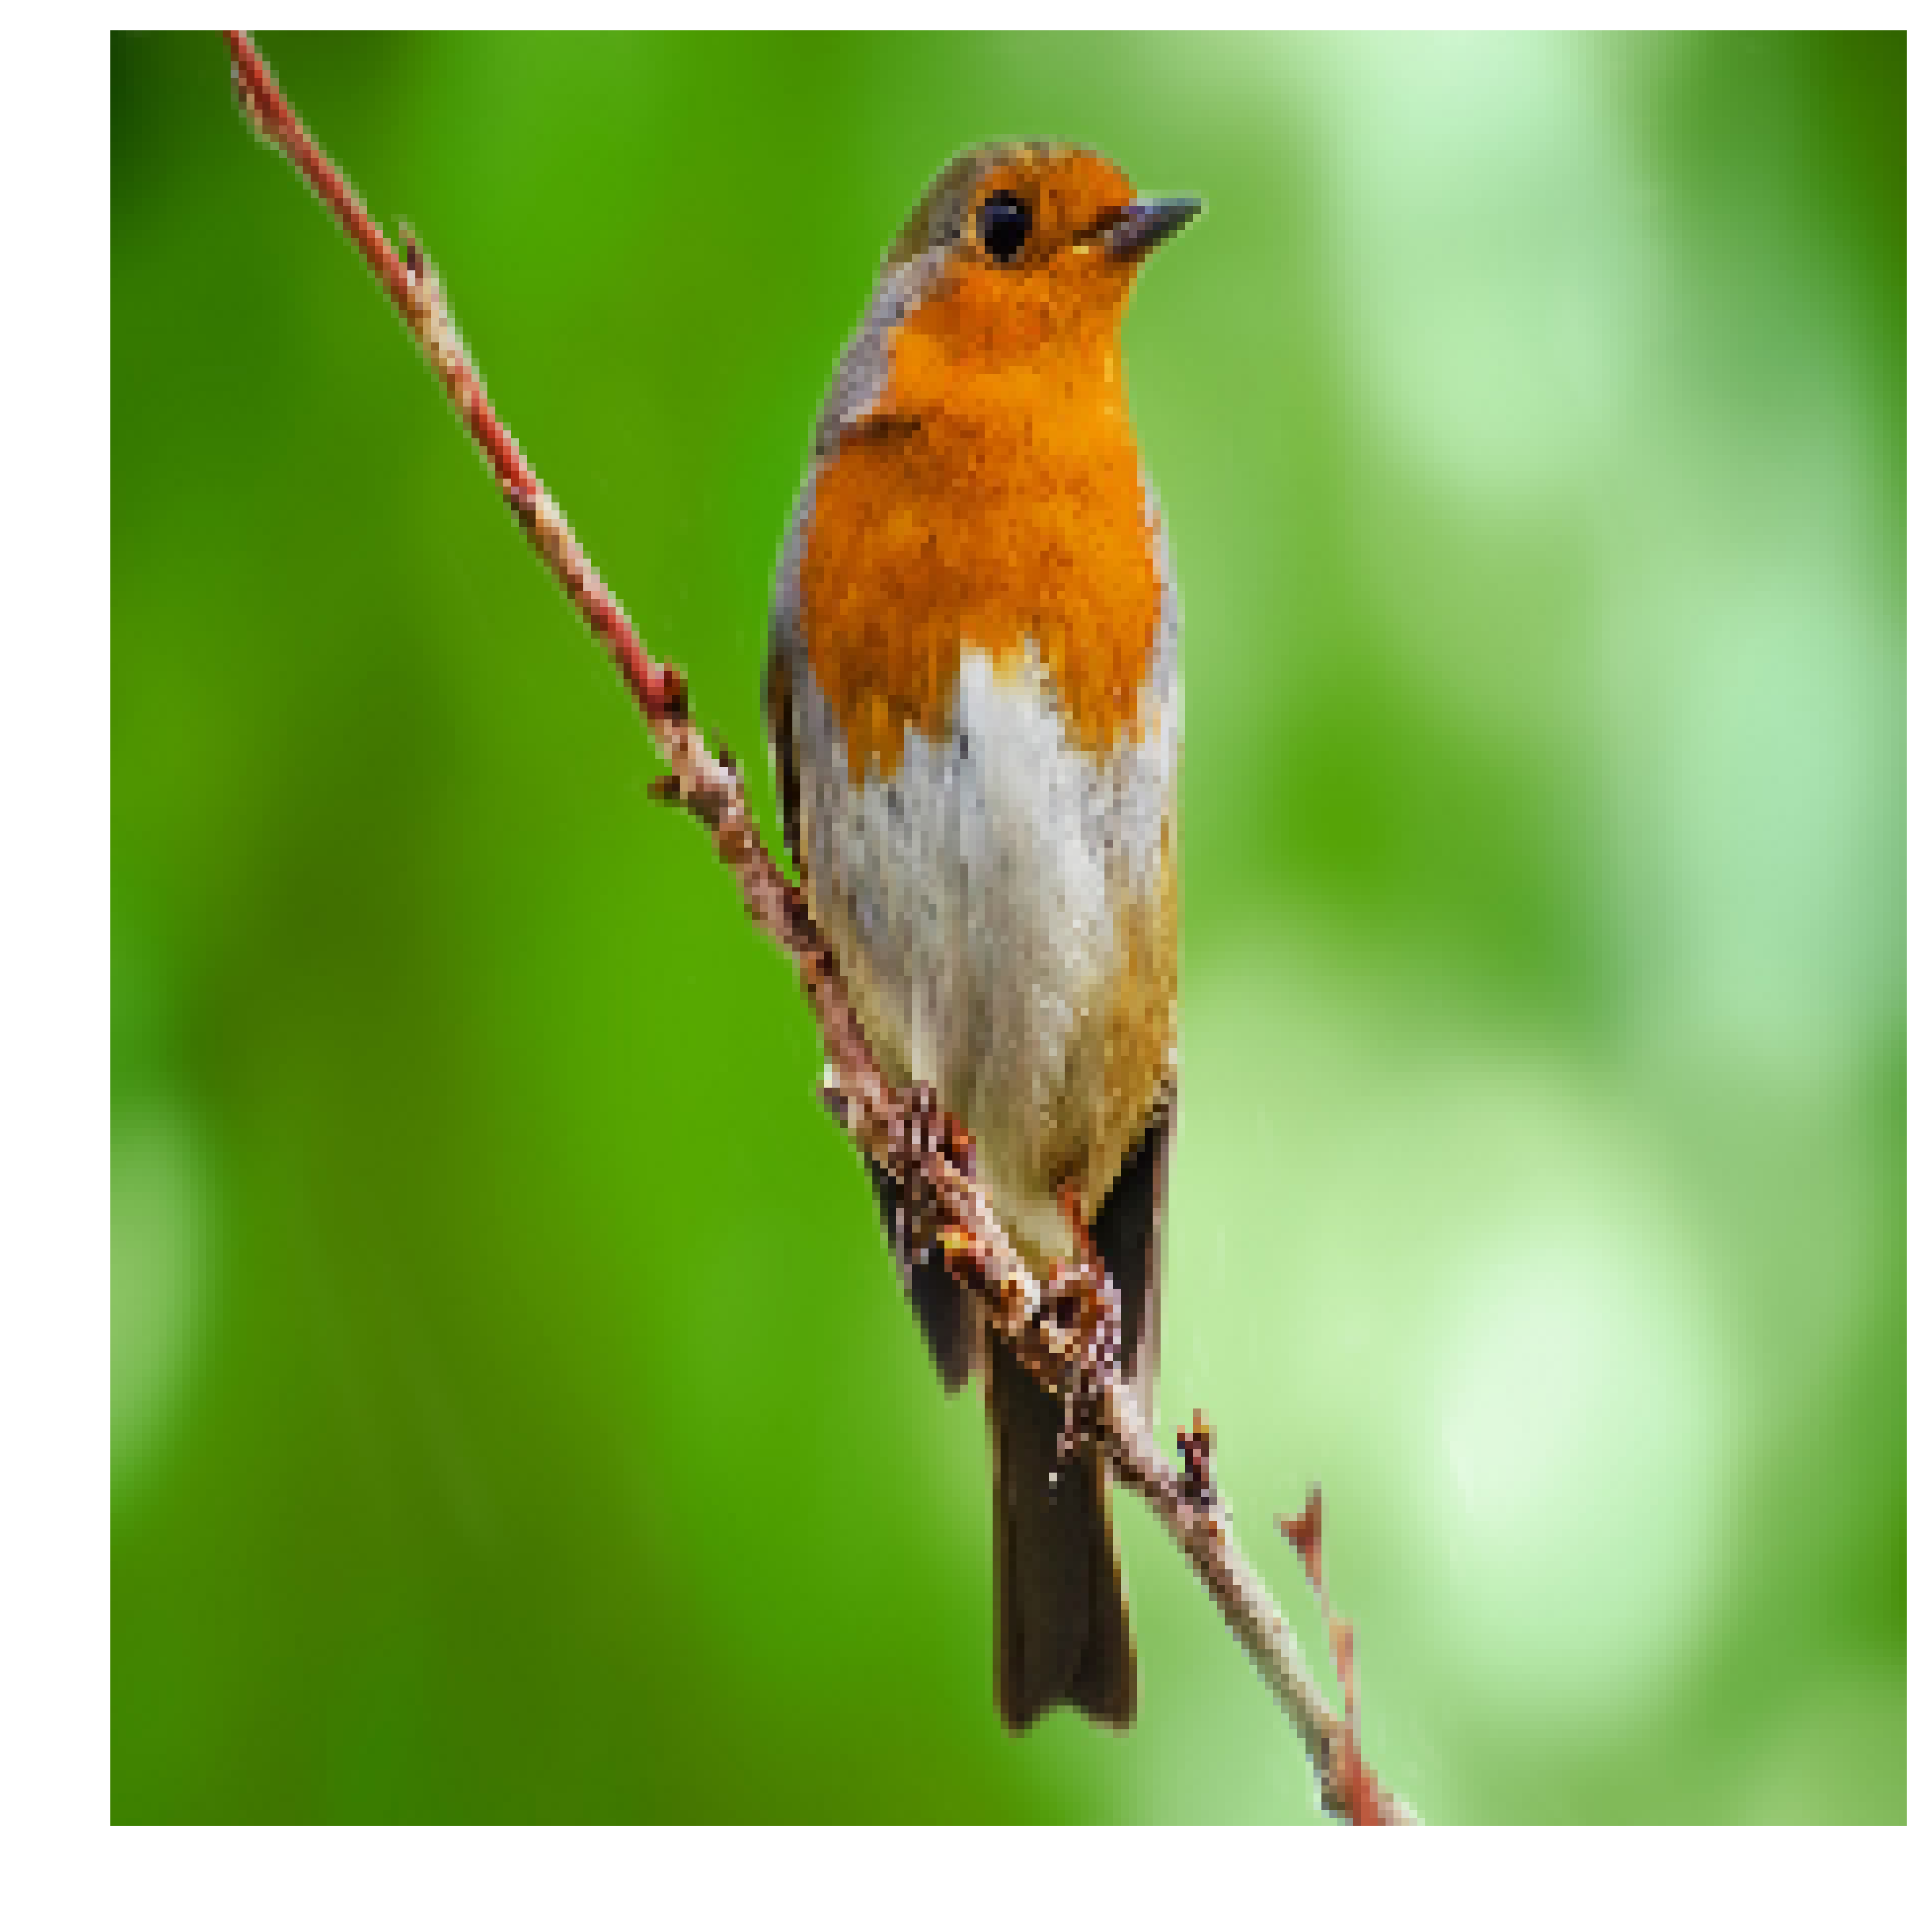

In [2]:
import cv2
import time 


img = cv2.imread('bird1.jpg', -1)
img = cv2.resize(img, (224, 224))

start = time.time() 
yhat = dense.predict(img.reshape(-1, 224, 224, 3))
time = time.time() - start
# label_key = np.argmax(yhat)
label = decode_predictions(yhat)
label = label[0][0]

print("테스트 시 소요 시간 : {}".format(time))
print('%s (%.2f%%)' % (label[1], label[2]*100))
img = img[:,:,::-1]
plt.figure(figsize=(11,11))
plt.imshow(img)
plt.axis("off")
plt.show()